# Azula Meets SBI: Benchmarking State-of-the-Art Sampling

This notebook demonstrates the integration of [Azula](https://github.com/dominik-roitsch/azula) samplers into `sbi`. We will key performance metrics:

1.  **Accuracy**: Using C2ST (Classifier 2-Sample Test) to measure how indistinguishable samples are from the ground truth.
2.  **Speed**: Measuring wall-clock time for sampling.
3.  **Visual Quality**: plotting marginal distributions.

We use a **Linear Gaussian** task where the exact ground truth posterior is available.

In [2]:
import time

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from torch import eye, ones, zeros
from torch.distributions import MultivariateNormal

from sbi.analysis import pairplot
from sbi.inference import FMPE
from sbi.simulators.linear_gaussian import (
    linear_gaussian,
    true_posterior_linear_gaussian_mvn_prior,
)
from sbi.utils.metrics import c2st

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
d:\sbi\.venv\Lib\site-packages\arviz\__init__.py:39: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


Using device: cpu


## 1. Task Setup: High-Dimensional Linear Gaussian

We use a 5-dimensional Linear Gaussian problem. This provides a non-trivial challenge for sampling while having an analytic solution for validation.

In [3]:
num_dim = 5
num_simulations = 4000

# 1. Define Priors and Simulator
x_o = zeros(1, num_dim).to(device)
likelihood_shift = -1.0 * ones(num_dim).to(device)
likelihood_cov = 0.3 * eye(num_dim).to(device)

prior_mean = zeros(num_dim).to(device)
prior_cov = eye(num_dim).to(device)
prior = MultivariateNormal(loc=prior_mean, covariance_matrix=prior_cov)

# 2. Generate Training Data
theta = prior.sample((num_simulations,))
x = linear_gaussian(theta, likelihood_shift, likelihood_cov)

# 3. Analytical Ground Truth
gt_posterior = true_posterior_linear_gaussian_mvn_prior(
    x_o.cpu(),
    likelihood_shift.cpu(),
    likelihood_cov.cpu(),
    prior_mean.cpu(),
    prior_cov.cpu()
)
gt_samples = gt_posterior.sample((1000,)).to(device)

## 2. Train Flow Matching Posterior Estimator (FMPE)

We train a continuous normalizing flow (CNF) using Flow Matching. This learns a time-dependent vector field that transports the prior to the posterior.

In [ ]:
inference = FMPE(prior, show_progress_bars=True, device=device)
inference.append_simulations(theta, x)
density_estimator = inference.train(max_num_epochs=50, learning_rate=5e-4)
posterior = inference.build_posterior(density_estimator)
posterior.set_default_x(x_o)

 Training neural network. Epochs trained: 51

VectorFieldPosterior sampler for potential_fn=<VectorFieldBasedPotential>

## 3. Benchmarking Samplers

We compare:
- **SBI Default**: Euler-Maruyama SDE solver.
- **Azula**: Heun (2nd order), Euler (1st order), and DDIM samplers.

We will vary the number of discretization steps to see the accuracy/speed trade-off.

In [5]:
def benchmark_sampler(method, predictor, steps, num_samples=1000):
    torch.manual_seed(42)
    t0 = time.time()

    if method == "azula":
        samples = posterior.sample(
            (num_samples,),
            sample_with="azula",
            predictor=predictor,
            predictor_params={"steps": steps},
            show_progress_bars=False
        )
    else:
        # SBI Default
        samples = posterior.sample(
            (num_samples,),
            sample_with="sde",
            steps=steps,
            show_progress_bars=False
        )

    t1 = time.time()
    elapsed = t1 - t0

    # Metrics
    # C2ST: 0.5 is optimal
    c2st_score = c2st(gt_samples.cpu(), samples.cpu()).item()
    mean_err = (samples.mean(0).cpu() - gt_samples.mean(0).cpu()).abs().mean().item()

    return {
        "Method": f"{method}-{predictor}" if predictor else method,
        "Steps": steps,
        "Time (s)": elapsed,
        "C2ST": c2st_score,
        "Mean Error": mean_err,
        "Samples": samples.cpu()
    }

results = []
configs = [
    ("sbi", "euler", 50),
    ("sbi", "euler", 100),
    ("azula", "heun", 20),
    ("azula", "heun", 50),
    ("azula", "euler", 50),
    ("azula", "ddim", 50),
]

print(f"Benchmarking {len(configs)} configurations...")
sample_store = {}

for method, pred, steps in configs:
    print(f"Running {method} ({pred}) with {steps} steps...")
    try:
        res = benchmark_sampler(method, pred, steps)
        sample_store[res["Method"] + f"_{steps}"] = res.pop("Samples")
        results.append(res)
        print(f" -> C2ST: {res['C2ST']:.4f}, Time: {res['Time (s)']:.2f}s")
    except Exception as e:
        print(f"Failed: {e}")
        import traceback
        traceback.print_exc()

df = pd.DataFrame(results)
df = df.sort_values("C2ST")
print("\nBenchmark Results:")
print(df.to_string())

Benchmarking 6 configurations...
Running sbi (euler) with 50 steps...
 -> C2ST: 0.6120, Time: 0.43s
Running sbi (euler) with 100 steps...
 -> C2ST: 0.5900, Time: 1.00s
Running azula (heun) with 20 steps...
 -> C2ST: 0.5685, Time: 7.47s
Running azula (heun) with 50 steps...
 -> C2ST: 0.5685, Time: 7.66s
Running azula (euler) with 50 steps...
 -> C2ST: 0.5655, Time: 3.51s
Running azula (ddim) with 50 steps...
 -> C2ST: 0.5660, Time: 4.30s

Benchmark Results:
        Method  Steps  Time (s)    C2ST  Mean Error
4  azula-euler     50  3.510848  0.5655    0.059306
5   azula-ddim     50  4.302025  0.5660    0.059306
3   azula-heun     50  7.655232  0.5685    0.059308
2   azula-heun     20  7.473844  0.5685    0.059308
1    sbi-euler    100  1.003178  0.5900    0.057768
0    sbi-euler     50  0.429135  0.6120    0.056218


## 4. Visualization

### 4.1 Pairplot Comparison
Comparing Ground Truth vs SBI (Euler) vs Azula (Heun) at 50 steps.

IndexError: list index out of range

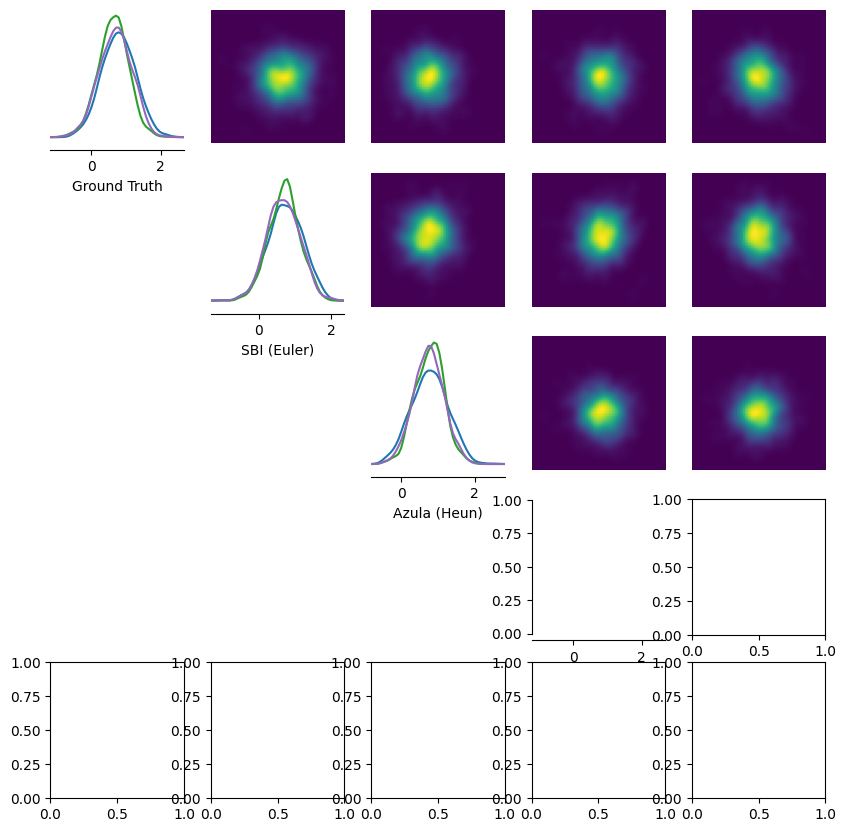

In [6]:
gt_np = gt_samples.cpu().numpy()
sbi_samples = sample_store.get("sbi-euler_50")
azula_samples = sample_store.get("azula-heun_50")

if sbi_samples is not None and azula_samples is not None:
    fig, ax = pairplot(
        [gt_np, sbi_samples.numpy(), azula_samples.numpy()],
        labels=["Ground Truth", "SBI (Euler)", "Azula (Heun)"],
        figsize=(10, 10),
        upper="kde",
        diag="kde"
    )
    plt.suptitle("Posterior Samples Comparison (50 Steps)")
    plt.show()

### 4.2 Performance Trade-off
Plotting Time vs Accuracy (C2ST).

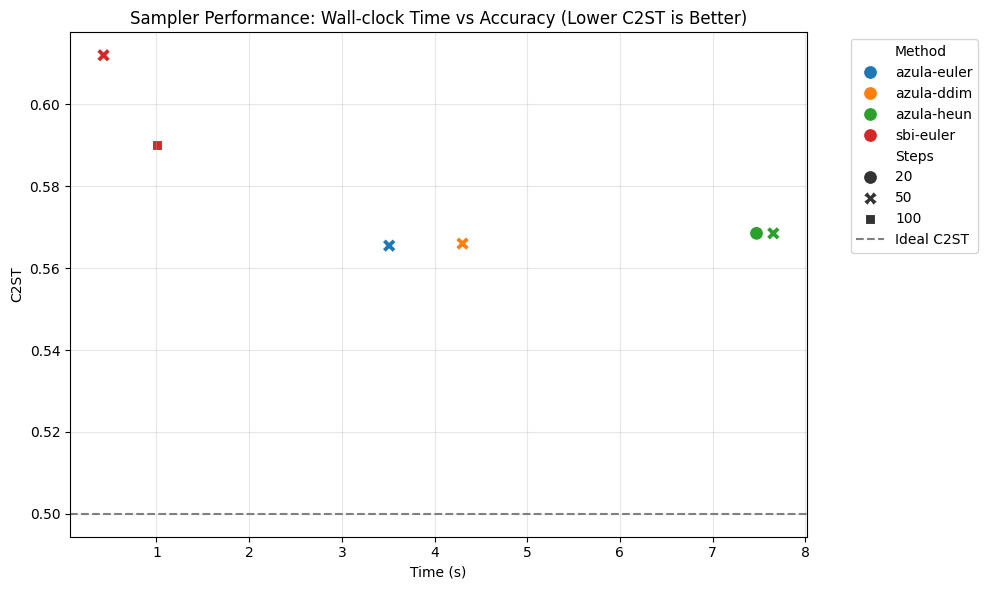

In [7]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Time (s)", y="C2ST", hue="Method", style="Steps", s=100)
plt.axhline(0.5, color="gray", linestyle="--", label="Ideal C2ST")
plt.title("Sampler Performance: Wall-clock Time vs Accuracy (Lower C2ST is Better)")
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()